# Analysis of DLS data
This Jupyter Notebook is designed for the analysis of 2D DLS data. 
- `df` should be a list of `.dat` files to be analysed and can be created with `glob`.
- Loaded DLS data is then fit to the `Cumulant` function to obtain required `gamma` values for each angle.
- For a given condition, each a plot of $\Gamma$ vs $q^2$ (which is a function of $\theta$) is made, where the gradient of the line of best fit is the diffusion coefficent. 
- The radius of hydration is then deduced using the Stokes-Einstein equation for each condition (i.e., temperature).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
from scipy import stats
import glob
import natsort
from tqdm import tqdm

from dls_analysis import (
    Cumulant,
    grab_metadata,
    data_loader,
    plot_data,
    q,
    plot_gamma,
    stokes_einstein,
)

In [2]:
print(np.__version__, scipy.__version__)

1.26.4 1.13.1


In [3]:
heatingcooling = True
plot = False

### Point `df` to the folder where your DLS data is saved

In [4]:
df = glob.glob("data/Measurement*.dat")
df = natsort.natsorted(df)

Load in the data files and fit the `Cumulant` function to them. Save results to an array.

In [5]:
results = []

In [6]:
for fh in tqdm(df):
    temp, theta = grab_metadata(fh)
    x, y = data_loader(fh)

    params, covariances = curve_fit(Cumulant, xdata=x, ydata=y)
    param_errs = np.sqrt(np.diag(covariances))
    gamma = params[1]
    gamma_err = param_errs[1]

    if plot:
        plot_data(x, y, params, temp, theta)

    results.append([temp, theta, params, param_errs])

  0%|          | 0/3895 [00:00<?, ?it/s]

100%|██████████| 3895/3895 [00:43<00:00, 89.32it/s] 


##### Process the results and separate by condition (i.e., temperature)

In [7]:
ti = 0  # set initial temp for loop
data = []

processed_results = {}

for i, r in enumerate(tqdm(results)):
    if r[0] == ti:
        data.append(r)

    else:
        processed_results[i] = data
        ti = r[0]
        data = []
        data.append(r)

processed_results[i] = data
del processed_results[0]

100%|██████████| 3895/3895 [00:00<00:00, 3858482.31it/s]


### Take the results (`processed_results`) and extract the diffusion coefficient from the gradient of $\Gamma$ vs $q^2$. Save deduced radius of hydration in `swelling_curve` array.

In [8]:
swelling_curve = []
angle_min = 0  # change this value to exlude some scattering angles

for k in tqdm(processed_results.keys()):
    df = processed_results[k]

    temp = df[0][0]
    gamma = []
    qs = []
    for i in df:
        if i[1] > angle_min:
            gamma.append(i[2][1])
            qs.append(q(i[1]))

    gamma = np.array(gamma)
    qs = np.array(qs)

    # ORGANISE IF THERE ARE MULTIPLE MEASUREMENTS AT EACH ANGLE

    uniq = []

    for xi in np.unique(qs**2):
        idx = np.where(qs**2 == xi)[0]

        uniq.append([xi, np.mean(gamma[idx]), np.std(gamma[idx])])

    uniq = np.array(uniq)

    # CALCULATE D, EXLUDING DATA POINTS BASED ON R^2 VALUE
    r2_threshold = 0.995  # change this to desired threshold

    D, b, r_value, p_value, std_err = stats.linregress(uniq[:, 0], uniq[:, 1])

    i = 0
    while r_value**2 < r2_threshold:
        i += 1
        D, b, r_value, p_value, std_err = stats.linregress(
            uniq[:-i, 0], uniq[:-i, 1]
        )

    if plot:
        plot_gamma(uniq, D, b, r_value, temp, i)

    rH, rH_err = stokes_einstein(temp, D, std_err)
    swelling_curve.append([temp, rH, rH_err])

swelling_curve = np.array(swelling_curve)

100%|██████████| 37/37 [00:00<00:00, 436.08it/s]


##### Plot the resultant swelling curve and save

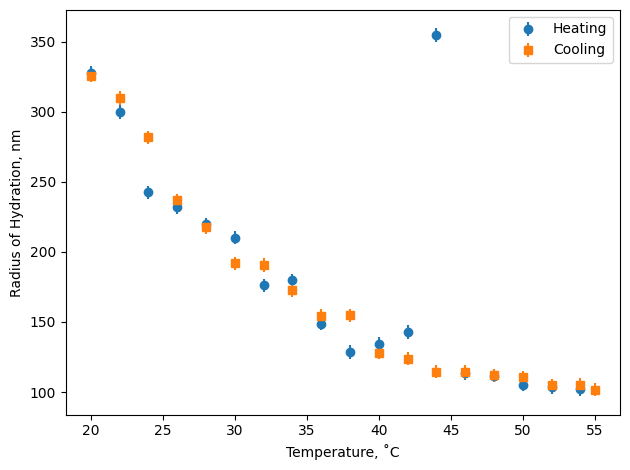

In [9]:
fig, ax = plt.subplots()

if heatingcooling:
    l = int(len(swelling_curve) / 2)
    ax.errorbar(
        swelling_curve[:l, 0],
        swelling_curve[:l, 1],
        yerr=rH_err,
        label="Heating",
        ls="",
        marker="o",
    )
    ax.errorbar(
        swelling_curve[l:, 0],
        swelling_curve[l:, 1],
        yerr=rH_err,
        label="Cooling",
        ls="",
        marker="s",
    )
else:
    ax.errorbar(swelling_curve[:, 0], swelling_curve[:, 1], yerr=rH_err)

ax.set_xlabel("Temperature, ˚C")
ax.set_ylabel("Radius of Hydration, nm")
ax.legend()

fig.tight_layout()
# fig.savefig('plots/_swelling_curve.pdf')

Export `swelling_curve` as a `.csv`

In [10]:
np.savetxt(
    "swelling_curve.csv", swelling_curve, header="temp, r, r_err", delimiter=","
)